# Pre-process

## Load library and define some functions needed

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import datetime as dt
import random

import json
import os.path
import gc

from script.lib.FeatureProducer import FeatureProducer 
MODEL_FILE_NAME = 'model.txt'

In [2]:
def custom_cv(params, train_set, hold_out_set=None, k_fold=5, num_boost_round=20):
    x_train = train_set.data
    y_train = train_set.label
    n = x_train.shape[0]
    unit = n // k_fold

    cv_scores = []
    for k in range(k_fold):
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        if k < k_fold - 1:
            continue
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        x_cv_valid = None
        y_cv_valid = None
        if k == k_fold - 1:
            x_cv_valid = x_train[unit * k:]
            y_cv_valid = y_train[unit * k:]
        else:
            x_cv_valid = x_train[unit * k: unit * (k + 1)]
            y_cv_valid = y_train[unit * k: unit * (k + 1)]

        x_cv_train = None
        y_cv_train = None
        if k == 0:
            x_cv_train = x_train[unit * (k + 1):]
            y_cv_train = y_train[unit * (k + 1):]
        elif k == k_fold - 1:
            x_cv_train = x_train[:unit * k]
            y_cv_train = y_train[:unit * k]
        else:
            x_cv_train = x_train[:unit * k].append(x_train[unit * (k + 1):])
            y_cv_train = y_train[:unit * k].append(y_train[unit * (k + 1):])

        cv_train_set = lgb.Dataset(x_cv_train, y_cv_train)
        cv_valid_set = lgb.Dataset(x_cv_valid, y_cv_valid)
        watchlist = [cv_valid_set]

        # not tested yet
        if hold_out_set is not None:
            watchlist.append(hold_out_set)
        model = lgb.train(params, train_set=cv_train_set, valid_sets=watchlist,
                          num_boost_round=num_boost_round, verbose_eval=5)
        print(model.best_score)
        cv_scores.append(model.best_score['valid_1']['auc'])

    tip_txt = '[CV]'
    tip_txt += ' ' + str(cv_scores)
    mean_cv_score = np.mean(cv_scores)
    tip_txt += '{ auc score=' + str(mean_cv_score) + ' }'
    print(tip_txt)

    return mean_cv_score

In [3]:
def custom_grid_search(params, own_grid_params, train_set, valid_set, num_boost_round=20):
    keys = []
    values = [list()]
    for key, value in own_grid_params.items():
        keys.append(key)
        new_values = []
        for item in values:
            for val in value:
                new_values.append(item + [val])
        values = new_values

    watchlist = [valid_set]
    grid_best_params = None
    grid_best_score = None

    for comb in values:
        own_params = {}
        for idx in range(len(keys)):
            own_params[keys[idx]] = comb[idx]
            params[keys[idx]] = comb[idx]

        cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=num_boost_round)

        tip_txt = '[GridSearch]'
        for idx in range(len(keys)):
            tip_txt += ' ' + str(keys[idx]) + '=' + str(comb[idx])
        tip_txt += ' { best_score: ' + str(cv_score) + ' }'
        print(tip_txt)

        if grid_best_score is None or cv_score > grid_best_score:
            grid_best_params, grid_best_score = own_params, cv_score

    tip_txt = '[GS Best Result]'
    for key, val in grid_best_params.items():
        tip_txt += ' ' + str(key) + '=' + str(val)
    tip_txt += ' { best_score: ' + str(grid_best_score) + ' }'
    print(tip_txt)
    
    return grid_best_params

## init

In [4]:
fp = FeatureProducer(root='./data')

## load

In [5]:
fp.load_raw()

12:37:59 INFO << load raw data in 20.17s


## preprocess

In [6]:
fp.pre_process()

12:38:29 INFO << parse train_df in 30.07s
12:38:46 INFO << parse test_df in 16.36s
12:38:46 INFO << parse members_df in 0.26s
12:39:07 INFO << parse songs_df in 20.12s
12:39:10 INFO << parse song_extra_info_df in 3.02s


## feature engineering

In [7]:
fp.feature_engineering()

12:40:07 INFO << parse engineering_df in 27.83s
12:40:29 INFO << parse engineering_df in 22.38s


## type to category

In [8]:
fp.self_fit_transform()

In [9]:
train_df = fp.train_df
test_df = fp.test_df

assert(train_df.shape[1] == test_df.shape[1])
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 42 columns):
msno                        category
song_id                     category
source_system_tab           category
source_screen_name          category
source_type                 category
target                      int64
1h_source                   int64
1h_system_tab               int64
1h_screen_name              int64
1h_source_type              int64
song_length                 float64
genre_ids                   category
artist_name                 category
composer                    category
lyricist                    category
language                    category
is_featured                 float64
artist_count                float64
artist_composer             float64
artist_composer_lyricist    float64
song_lang_boolean           float64
genre_count                 float64
composer_count              float64
lyricist_count              float64
1h_lang                

# LGBM training

## Correlation over all features (underconstruction...)

For categorical feature, need to numerize them.
Also, for all numeric features, it's necessary to be normalized.

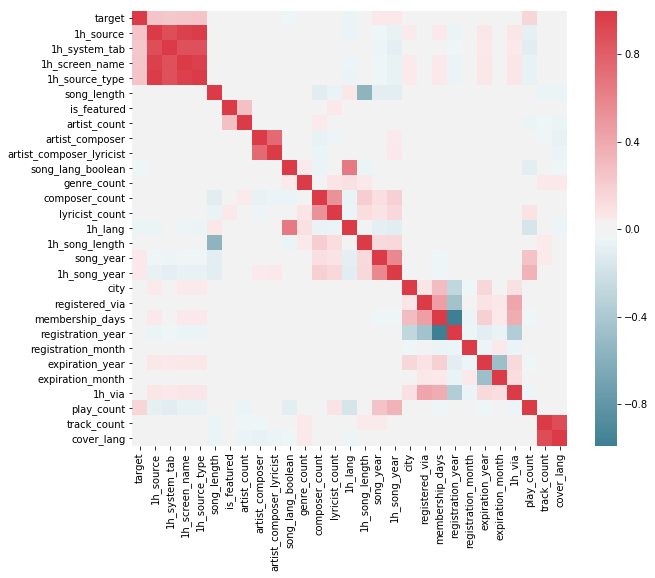

In [10]:
corr = train_df.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## Prepare

In [11]:
x = train_df.drop(['target'], axis=1)
y = train_df['target']

# take the last # rows of train_df as valid set where # means number of rows in test_df
x_valid = train_df.drop(['target'], axis=1).tail(test_df.shape[0])
y_valid = train_df['target'].tail(test_df.shape[0])

x_test = test_df.drop(['id'], axis=1)
test_ids = test_df['id']

train_df.head(15)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,1h_source,1h_system_tab,1h_screen_name,1h_source_type,...,expiration_date,membership_days,registration_year,registration_month,expiration_year,expiration_month,1h_via,play_count,track_count,cover_lang
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,0,0,0,0,...,2017-10-05,2103,2012,1,2017,10,1,215,84.0,1.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,1,1,1,1,...,2017-09-11,2301,2011,5,2017,9,1,1,17080.0,10.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,1,1,1,1,...,2017-09-11,2301,2011,5,2017,9,1,4,61.0,2.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,1,1,1,1,...,2017-09-11,2301,2011,5,2017,9,1,1,1.0,1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,0,0,0,0,...,2017-10-05,2103,2012,1,2017,10,1,412,6.0,1.0
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,0,0,0,0,...,2017-10-05,2103,2012,1,2017,10,1,1108,15.0,1.0
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1,1,1,1,1,...,2017-09-11,2301,2011,5,2017,9,1,3869,43.0,1.0
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,0,0,0,0,...,2017-10-05,2103,2012,1,2017,10,1,287,33.0,1.0
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1,1,1,1,1,...,2018-03-04,2309,2011,11,2018,3,1,31,155.0,2.0
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1,1,1,1,1,...,2018-03-04,2309,2011,11,2018,3,1,738,155.0,2.0


## Core

In [12]:
train_set = lgb.Dataset(x, y)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'learning_rate': 0.2,
    'application': 'binary',
    'min_data_in_leaf': 10,
#    'max_depth': 10,
    'num_leaves': 2 ** 7,
    'max_bin': 255,
    'verbosity': 0,
    'metric': 'auc'
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

# best_grid_params = custom_grid_search(params, grid_params, train_set, hold_out_set, num_boost_round=20)
# for key, val in best_grid_params.items():
#     params[key] = best_grid_params[key]

cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=5)
print(cv_score)

model = lgb.train(params, train_set=train_set, valid_sets=watchlist, num_boost_round=5, verbose_eval=5)
y_test = model.predict(x_test)

# When CV, valid_0 means the front 75% training, the last 25% validating
#          valid_1 means the front 75% training, the last "len(test set)" validating
#
# When LGBM running, valid_0 means 100% training, the last "len(test set)" validating.
#
# Use CV valid_0 auc score to predict result!

[5]	valid_0's auc: 0.655384	valid_1's auc: 0.670802
defaultdict(<class 'dict'>, {'valid_0': {'auc': 0.6553838494844193}, 'valid_1': {'auc': 0.67080241566192178}})
[CV] [0.67080241566192178]{ auc score=0.670802415662 }
0.670802415662
[5]	valid_0's auc: 0.695442


## Feature importances

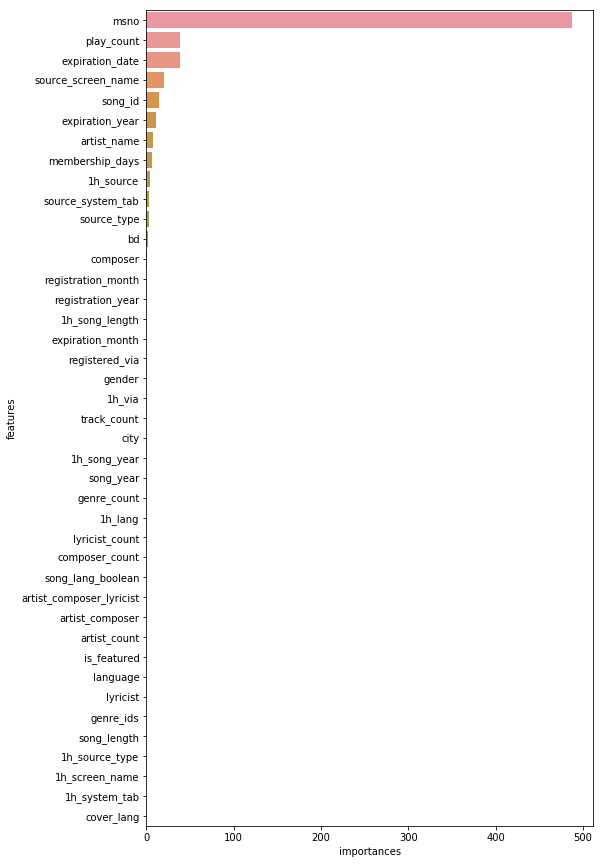

In [13]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'target'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)

plt.figure(figsize=(8, 15))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

## Output

In [14]:
submission_df = pd.DataFrame()
submission_df['id'] = test_ids
submission_df['target'] = y_test
# string file compression reduces file size
submission_df.to_csv('data/submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 2 columns):
id        int64
target    float64
dtypes: float64(1), int64(1)
memory usage: 58.5 MB
